c:\Users\gabri\anaconda3\envs\machine_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(2, 14000)
####### Data loaded successfully. #######  
 Data Status: 
  num_processes:  2 
  num_timesteps:  14000 
 sum_of_first_poisson_process:  tensor(5531., dtype=torch.float64) 
 sum_of_first_thinned_process:  tensor(401., dtype=torch.float64)


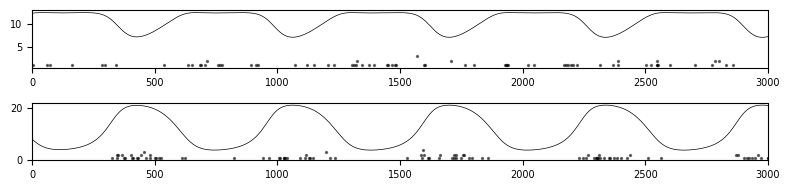

In [1]:
import os
import gc
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
from dynamical_system import ODE
from helpers.helpers import Helper
from variational_inference.variational_inference import VariationalInference
from variational_inference.optimization_loop import optimization_loop
from data_generation.data_generator import DataGenerator
from time_grid_optimization.time_grid_optimizer2 import Time_grid_optimizer2
from time_series.ts_Helper import TS_Helper
from helpers.plotter import plot_loss, plot_big_time_grid, plot_time_grid, plot_time_grid_kernel

######### load data #########
folder_name = 'data_generation\\generated_data'
name = 'marked_T14000_n2_mu0.5.npz'
file_path = os.path.join(folder_name, name)
loaded_data = np.load(file_path)
full_gp_samples = loaded_data['gp_samples']
full_poisson_process = loaded_data['poisson_process']
full_thinned_process = loaded_data['thinned_process']
print(full_thinned_process.shape)

full_gp_samples = torch.tensor(full_gp_samples, dtype=torch.float64)
gp_samples = full_gp_samples[:, :10000] #!!!!!   cut down to train size    !!!!!
full_poisson_process = torch.tensor(full_poisson_process, dtype=torch.float64)
full_thinned_process = torch.tensor(full_thinned_process, dtype=torch.float64)

DataGenerator.print_data_status(full_gp_samples, full_poisson_process, full_thinned_process)
DataGenerator.plot_marked_data(full_gp_samples, full_poisson_process, full_thinned_process, xlim=3000)
num_processes = full_thinned_process.shape[0]

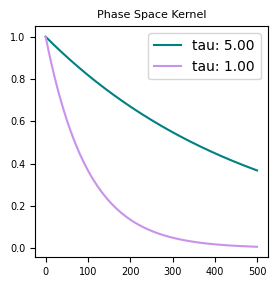

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Initial time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


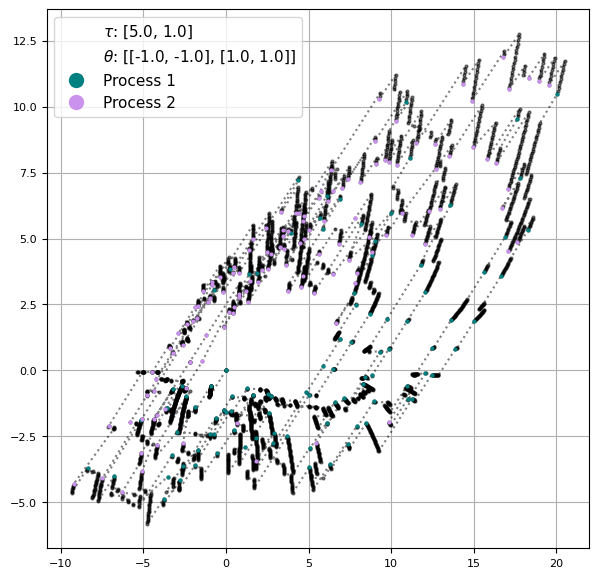



@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: 1   @@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


############ Optimization Process: 1 (15 Iterations) ############
   ## iteration: 1, L: -16.42, time for iteration: 1.39s ##
   ## iteration: 2, L: 3.08, time for iteration: 1.19s ##
   ## iteration: 3, L: 5.53, time for iteration: 1.31s ##
   ## iteration: 4, L: 7.28, time for iteration: 1.25s ##
   ## iteration: 5, L: 8.51, time for iteration: 1.66s ##

   ######  hyperparameter optimization (8 Epochs)  ######
   new kernel lengthscale 9.983617220538838
   ## L after hyper opt: 8.65, time for hyper opt: 6.99s ##

   ## iteration: 6, L: 9.59, time for iteration: 1.22s ##
   ## iteration: 7, L: 10.16, time for iteration: 1.20s ##
   ## iteration: 8, L: 10.55, time for iteration: 1.50s ##
   ## iteration: 9, L: 10.81, time for iteration: 1.39s ##
   ## iteration: 10, L: 10.98, time for iter

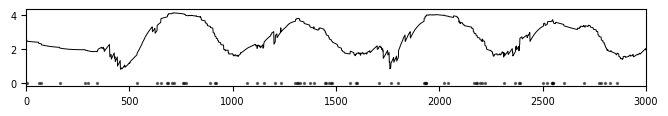



############ Optimization Process: 2 (15 Iterations) ############
   ## iteration: 1, L: 228.29, time for iteration: 1.56s ##
   ## iteration: 2, L: 288.97, time for iteration: 1.30s ##
   ## iteration: 3, L: 313.39, time for iteration: 1.35s ##
   ## iteration: 4, L: 327.25, time for iteration: 1.64s ##
   ## iteration: 5, L: 335.55, time for iteration: 1.54s ##

   ######  hyperparameter optimization (8 Epochs)  ######
   new kernel lengthscale 10.040368181809722
   ## L after hyper opt: 336.82, time for hyper opt: 8.12s ##

   ## iteration: 6, L: 342.35, time for iteration: 1.25s ##
   ## iteration: 7, L: 346.14, time for iteration: 1.38s ##
   ## iteration: 8, L: 348.62, time for iteration: 1.34s ##
   ## iteration: 9, L: 350.27, time for iteration: 1.44s ##
   ## iteration: 10, L: 351.34, time for iteration: 2.22s ##
   ## iteration: 11, L: 352.04, time for iteration: 1.38s ##
   ## iteration: 12, L: 352.48, time for iteration: 1.50s ##
   ## iteration: 13, L: 352.74, time for i

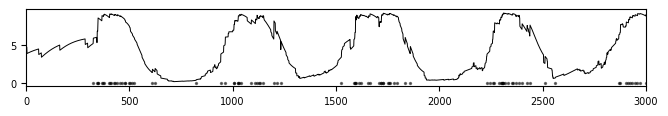

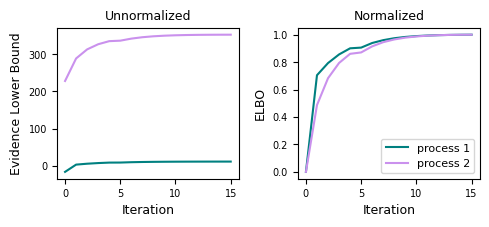


@@@@@@@@@@@@ time grid optimization (30 Epochs)  @@@@@@@@@@@@



In [ ]:
list_vi_objects = []
loss_tracker_all_processes = []
global_opt_time_tracker = 0
global_hyperparam_time_tracker = 0
global_phase_space_time_tracker = 0

###### define parameters ######
'''    !! end_time x time_discretization will be the train split !!    '''
end_time                         = 100         # end time of the data
time_discretization              = 100         # diskretizaiton of the time
time_grid_kernel_effect_length   = 5           # length of the kernel in time grid space (for tau<1 the log(tau) is added to the length)
dim_phase_space                  = 2 #!!!      # attention, on initialization of tau and couplings
tau_list                         = [5,1]
gp_kernel                        = 'RBF'       # 'RBF' or 'Matern'

if type(full_thinned_process) == torch.Tensor:
    list_full_processes = []
    list_processes = []
    for i in range(num_processes):
        list_full_processes.append(full_thinned_process[i])
        list_processes.append(full_thinned_process[i, :end_time*time_discretization])
elif type(full_thinned_process) == np.ndarray:
    list_full_processes = []
    list_processes = []
    for i in range(num_processes):
        list_full_processes.append(torch.tensor(full_thinned_process[i], dtype=torch.float64))
        list_processes.append(torch.tensor(full_thinned_process[i, :end_time*time_discretization]), dtype=torch.float64)
elif type(full_thinned_process) == list:
    list_processes = []
    for i in range(num_processes):
        list_processes = full_thinned_process[i][:end_time*time_discretization]
else:
    raise ValueError('thinned_process must be a list, numpy array or torch tensor')

seed_value = 14
torch.manual_seed(seed_value)
tau_list =       torch.tensor(tau_list, dtype=torch.float64)
couplings =     torch.zeros(num_processes, dim_phase_space, dtype=torch.float64)
couplings[0] =  torch.tensor([-1,-1], dtype=torch.float64)  
couplings[1] =  torch.tensor([1,1], dtype=torch.float64)
#couplings[2] =  torch.tensor([1,1], dtype=torch.float64) 
#couplings[3] =  torch.tensor([-1,-1], dtype=torch.float64)

#couplings =      (torch.rand(num_processes, dim_phase_space) * 2) - 1

time_grid_parameters = {
    'tau_list':           tau_list,
    'couplings':          couplings,}
optimality_parameters = {
    "alpha_post":         None,
    "beta_post":          None,
    "mu_post":            None,
    "cov_post":           None }
hyperparameters = {
    'kernel_outputscale':     torch.tensor(6. , dtype=torch.float64),
    'kernel_lengthscale':     torch.tensor(10. , dtype=torch.float64),
    'alpha_0':                torch.tensor(4 , dtype=torch.float64),
    'beta_0':                 torch.tensor(1 , dtype=torch.float64),
    'GP_prior_mean':          torch.tensor(.0 , dtype=torch.float64),
    'inducing_points_s':      None,
    'tau_list':               tau_list,
    'couplings':              couplings}

###### define parameters ######
algorithm_iterations          = 5           # number of iterations alternating between time-grid opt and per process opt
iterations_per_process        = 8           # num iteratons of optimality update per process per algorithm iteration

epochs_per_hyp_tuning         = 8
epochs_time_grid              = 30
time_hyp_opt                  = [5]      # at which iteration to optimize the hyperparameters per prcoess

learning_rate_optimization    = 0.05
learning_rate_tau             = 0.05
learning_rate_couplings       = 0.05

termination_threshold_opt     = .1          # threshold for the loss to terminate ooptimality update per process
termination_threshold_tg      = 1.
gradient_clip_norm            = 3000.
num_inducing_points_per_dim   = 10          # gets raised by the power of dim of phase space

ts_helper = TS_Helper(full_thinned_process, full_gp_samples, dim_phase_space, num_processes, end_time, time_grid_kernel_effect_length, time_discretization)
#global_opt = Time_grid_optimizer2(list_vi_objects, ts_helper, time_grid_parameters, learning_rate_tau, learning_rate_couplings, epochs_time_grid, gradient_clip_norm, termination_threshold_tg)
plot_time_grid_kernel(ts_helper, tau_list, size=3)

print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Initial time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
time_grid = ts_helper.get_time_grid(couplings, tau_list)
plot_big_time_grid(ts_helper, time_grid, size=7, start=0, end=4000, tau_list=tau_list, couplings=couplings)

start_time= time.time()
for i in range(algorithm_iterations):
    print("\n")
    print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print(f'@@@@@@@@@@@@@@@@@@@  Algorithm Iteration: {i+1}   @@@@@@@@@@@@@@@@@@')
    print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
    print("\n")
    list_vi_objects, loss_tracker_all_processes, global_full_stack_params, hyperparam_time_tracker, opt_time_tracker = optimization_loop(i,
                        list_full_processes, optimality_parameters, hyperparameters, time_grid_parameters, 
                        ts_helper, num_inducing_points_per_dim, learning_rate_optimization, time_hyp_opt, 
                        termination_threshold_opt, iterations_per_process, epochs_per_hyp_tuning,
                        list_vi_objects, loss_tracker_all_processes, gp_kernel #, global_full_stack_params
                        )
    plot_loss(loss_tracker_all_processes, size=2.5)
    global_hyperparam_time_tracker += hyperparam_time_tracker
    global_opt_time_tracker += opt_time_tracker

    if i <= algorithm_iterations-2:
        #device = torch.device("cpu")
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        global_opt = Time_grid_optimizer2(device, list_vi_objects, ts_helper, time_grid_parameters, learning_rate_tau, learning_rate_couplings, epochs_time_grid, gradient_clip_norm, termination_threshold_tg)
        global_opt.to(device)        #global_opt.set_vi_objects(list_vi_objects)
        time_grid_parameters, time_tracker = global_opt.optimize_time_grid(list_vi_objects)
        global_opt.to_cpu()
        global_phase_space_time_tracker += time_tracker
        Helper.set_time_grid_params(list_vi_objects, time_grid_parameters)
        del global_opt
        gc.collect()
end_time = time.time()

print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')
print(f'@@@@@@@@@@@@@@@@@@@    Algorithm terminated   @@@@@@@@@@@@@@@@@@')
print(f'@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@')


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting EBLO @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

   ELBO of process 0: 3804.13
   ELBO of process 1: 1518.25

   ### Global ELBO: 5322.38 ###

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Runtime @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

   time for optimization: 89.83s
   time for hyperparameter optimization: 43.55s
   time for phase space optimization: 60.45s

   ### overall time used: 227.95s ###

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@


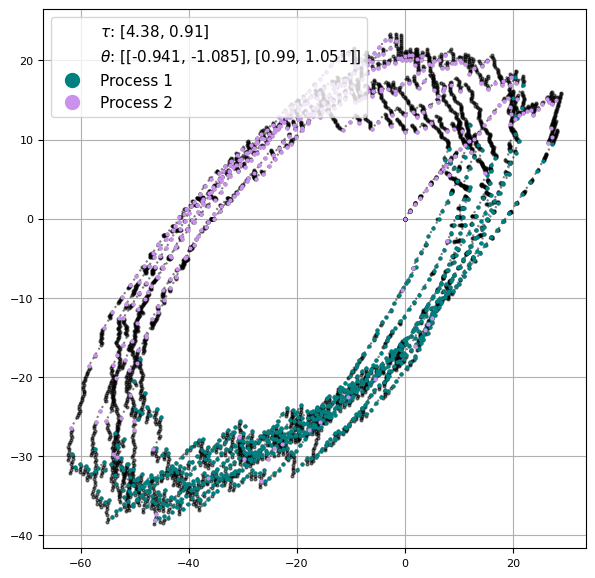

In [3]:
print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting EBLO @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n")
globad_ELBO = 0
for i, tensor in enumerate(loss_tracker_all_processes):
    last_element = tensor[-1]
    print(f"   ELBO of process {i}: {last_element:.2f}")
    globad_ELBO += last_element
print(f"\n   ### Global ELBO: {globad_ELBO:.2f} ###\n")


print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Runtime @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@\n")
print(f"   time for optimization: {global_opt_time_tracker:.2f}s")
print(f"   time for hyperparameter optimization: {global_hyperparam_time_tracker:.2f}s")
print(f"   time for phase space optimization: {global_phase_space_time_tracker:.2f}s")
print(f"\n   ### overall time used: {end_time-start_time:.2f}s ###\n")

print("@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ Resulting time-grid @@@@@@@@@@@@@@@@@@@@@@@@@@@@@")
time_grid = ts_helper.get_time_grid(time_grid_parameters['couplings'], time_grid_parameters['tau_list'])
plot_big_time_grid(ts_helper, time_grid, size=7, start=0, end=5000, tau_list=time_grid_parameters['tau_list'], couplings=time_grid_parameters['couplings'])

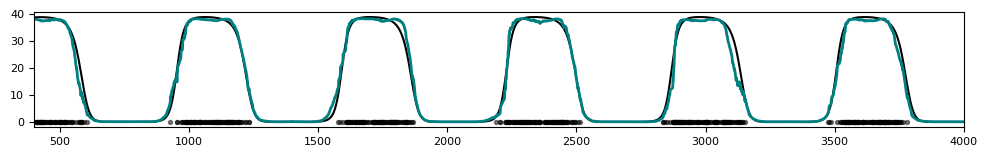

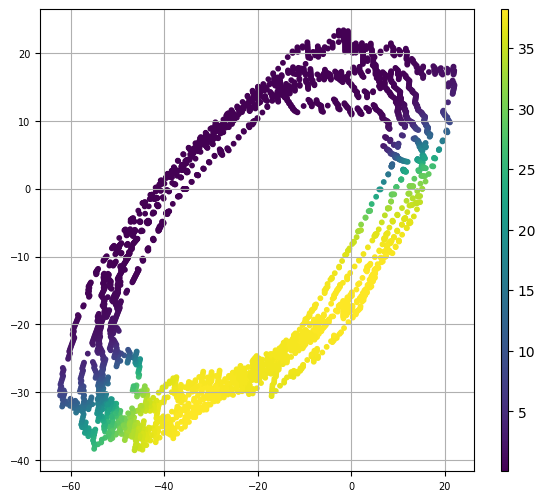

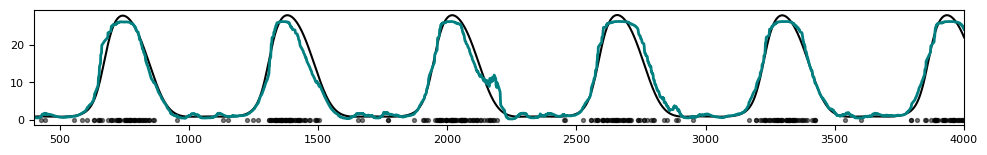

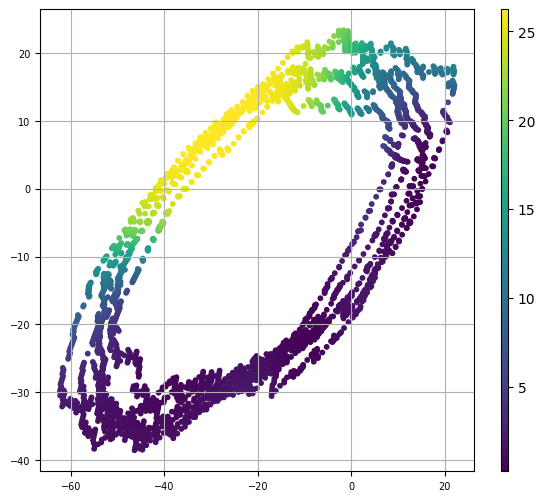

In [4]:
# plot results
for i, vi in enumerate(list_vi_objects):
    vi.loss_tracker_all = loss_tracker_all_processes
    vi.cal_predictive_rate()
    vi.plot_results(gp_samples[i],  c_map='viridis', start=400, xlim=4000)
    #vi.plot_surface(points_per_axis=50, start=400, xlim=3000)

In [5]:
#save as pickle
import pickle
folder_name = 'stored_runs'
#name = f'{name}.pickle'
file_path = os.path.join(folder_name, name)
print(file_path)
with open(file_path, 'wb') as file:
    pickle.dump(list_vi_objects, file)

stored_runs\data_arrays_T14000_n2_mu0.5.npz
